In [ ]:
# pip install -U scikit-learn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)

In [ ]:
df = pd.read_excel('/Users/talhabinomar/Desktop/Assignments/5th Semester/Data Mining/DM Project/GamingStudy_data.xlsx')

df.head()

,Unnamed: 0,Zeitstempel,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.004366,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.006803,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.038599,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.068037,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintances or teammates,Accept,0,17,11.0,USA,USA
4,5,42052.089478,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA


In [ ]:
df.columns

Index(['Unnamed: 0', 'Zeitstempel', 'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5',
       'GAD6', 'GAD7', 'GADE', 'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'Game',
       'Platform', 'Hours', 'earnings', 'whyplay', 'League', 'highestleague',
       'streams', 'SPIN1', 'SPIN2', 'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6',
       'SPIN7', 'SPIN8', 'SPIN9', 'SPIN10', 'SPIN11', 'SPIN12', 'SPIN13',
       'SPIN14', 'SPIN15', 'SPIN16', 'SPIN17', 'Narcissism', 'Gender', 'Age',
       'Work', 'Degree', 'Birthplace', 'Residence', 'Reference', 'Playstyle',
       'accept', 'GAD_T', 'SWL_T', 'SPIN_T', 'Residence_ISO3',
       'Birthplace_ISO3'],
      dtype='object')

In [ ]:
print(df.describe())

         Unnamed: 0   Zeitstempel          GAD1          GAD2          GAD3  \
count  13464.000000  13464.000000  13464.000000  13464.000000  13464.000000   
mean    7096.839201  42054.841222      0.860963      0.673351      0.965761   
std     4114.478220      0.272948      0.926542      0.915724      0.982776   
min        1.000000  42052.004366      0.000000      0.000000      0.000000   
25%     3532.750000  42054.716545      0.000000      0.000000      0.000000   
50%     7087.500000  42054.800677      1.000000      0.000000      1.000000   
75%    10654.250000  42054.932115      1.000000      1.000000      2.000000   
max    14250.000000  42058.363746      3.000000      3.000000      3.000000   

               GAD4          GAD5          GAD6          GAD7          SWL1  \
count  13464.000000  13464.000000  13464.000000  13464.000000  13464.000000   
mean       0.724079      0.488042      0.911022      0.588755      3.720440   
std        0.921971      0.837014      0.931168    

In [ ]:
print(df["GADE"].head())

0    Not difficult at all
1      Somewhat difficult
2    Not difficult at all
3    Not difficult at all
4          Very difficult
Name: GADE, dtype: object


In [ ]:
print(df.isnull().sum())

Unnamed: 0             0
Zeitstempel            0
GAD1                   0
GAD2                   0
GAD3                   0
GAD4                   0
GAD5                   0
GAD6                   0
GAD7                   0
GADE                 649
SWL1                   0
SWL2                   0
SWL3                   0
SWL4                   0
SWL5                   0
Game                   0
Platform               0
Hours                 30
earnings               0
whyplay                0
League              1852
highestleague      13464
streams              100
SPIN1                124
SPIN2                154
SPIN3                140
SPIN4                159
SPIN5                166
SPIN6                156
SPIN7                138
SPIN8                144
SPIN9                158
SPIN10               160
SPIN11               187
SPIN12               168
SPIN13               187
SPIN14               156
SPIN15               147
SPIN16               147
SPIN17               175


In [ ]:
df["Reference"].unique()

array(['Reddit', 'Other', 'TeamLiquid.net', 'CrowdFlower', nan],
      dtype=object)

In [ ]:
# ===============================
# 1. DROPPING UNNECESSARY COLUMNS Which includes index and timestamp columns
# ===============================
df.drop(columns=['Unnamed: 0', 'Zeitstempel'], inplace=True, errors='ignore')

# Dropping League columns due to excessive missing values
df.drop(columns=['League', 'highestleague'], inplace=True, errors='ignore')
df.drop(columns=['accept'], inplace=True, errors='ignore')

# ===============================
# 2. SPIN QUESTIONS (Item-wise median imputation as column is in discrete scale)
# ===============================
spin_cols = [f'SPIN{i}' for i in range(1, 18)]
for col in spin_cols:
    df[col] = df[col].fillna(df[col].median())

# ===============================
# 3. RE-CALCULATING SPIN TOTAL
# ===============================
df['SPIN_T'] = df[spin_cols].sum(axis=1)

# ===============================
# 4. Imputation with Mode for GAD_E (as per scale)
# ===============================
df['GADE'] = df['GADE'].fillna(df['GADE'].mode()[0])


# ===============================
# 5. NUMERICAL COLUMNS
# ===============================

# Hours → skewed → median
df['Hours'].fillna(df['Hours'].median(), inplace=True)

# Narcissism → LIKERT scale-based → Median
df['Narcissism'] = df['Narcissism'].fillna(df['Narcissism'].median())

# Age -> Left Skewed -> median
df['Age'].fillna(df['Age'].median(), inplace=True)

# ===============================
# 6. CATEGORICAL COLUMNS
# ===============================
# Since Stream column is cross-sectional count-like data we will use Iterative Imputer for better accuracy and to preserve variance
features = [
    'streams', 'SPIN_T', 'GAD_T', 'SWL_T',
    'Narcissism', 'Age'
]

imp = IterativeImputer(
    random_state=42,
    max_iter=10
)

df[features] = imp.fit_transform(df[features])

df['streams'] = df['streams'].clip(lower=0)



# Work → mode
df['Work'].fillna(df['Work'].mode()[0], inplace=True)

# Degree → label missing as Unknown
df['Degree'].fillna('Unknown', inplace=True)

# Reference → Unknown
df['Reference'] = df['Reference'].fillna(df['Reference'].mode()[0])



# ===============================
# 7. DROP COLUMNS WITH EXCESSIVE MISSING
# ===============================
df.drop(columns=['League', 'highestleague'], inplace=True, errors='ignore')


# ===============================
# 8. COUNTRY CODES → MODE
# ===============================
# Since Less then 5% data is missing we will use Mode for imputation
df['Residence_ISO3'].fillna(df['Residence_ISO3'].mode()[0], inplace=True)
df['Birthplace_ISO3'].fillna(df['Birthplace_ISO3'].mode()[0], inplace=True)




/var/folders/l2/hhvh4b6909x5cvzd31z01gl40000gn/T/ipykernel_41070/1170120380.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Hours'].fillna(df['Hours'].median(), inplace=True)
/var/folders/l2/hhvh4b6909x5cvzd31z01gl40000gn/T/ipykernel_41070/1170120380.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [ ]:
# ===============================
# 9. FINAL CHECK
# ===============================
print(df.isnull().sum())


GAD1               0
GAD2               0
GAD3               0
GAD4               0
GAD5               0
GAD6               0
GAD7               0
GADE               0
SWL1               0
SWL2               0
SWL3               0
SWL4               0
SWL5               0
Game               0
Platform           0
Hours              0
earnings           0
whyplay            0
streams            0
SPIN1              0
SPIN2              0
SPIN3              0
SPIN4              0
SPIN5              0
SPIN6              0
SPIN7              0
SPIN8              0
SPIN9              0
SPIN10             0
SPIN11             0
SPIN12             0
SPIN13             0
SPIN14             0
SPIN15             0
SPIN16             0
SPIN17             0
Narcissism         0
Gender             0
Age                0
Work               0
Degree             0
Birthplace         0
Residence          0
Reference          0
Playstyle          0
GAD_T              0
SWL_T              0
SPIN_T       

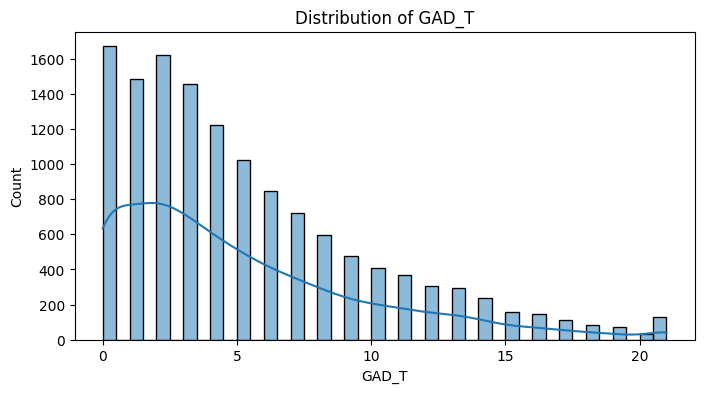

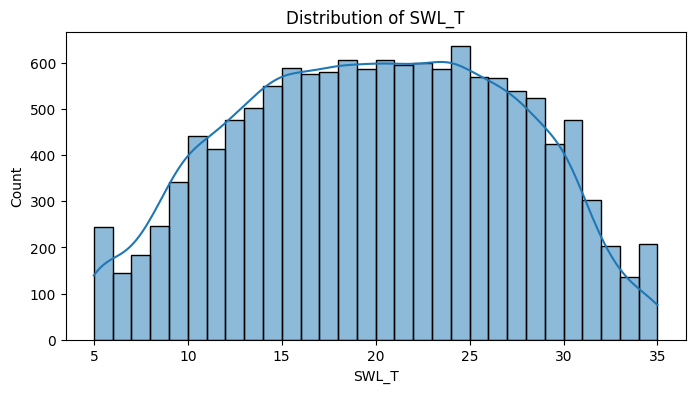

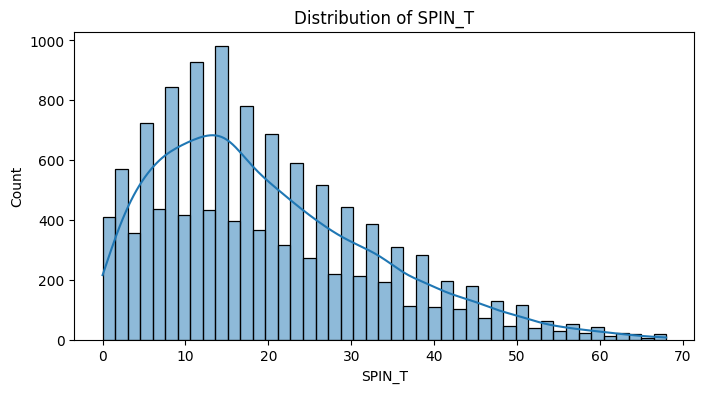

In [ ]:

# Histograms for mental health scores
for col in ['GAD_T', 'SWL_T', 'SPIN_T']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


Goal: Predict whether a gamer is at clinically relevant anxiety risk based on their gaming behavior + demographics + other psych scales.

A standard GAD-7 cutoff is GAD_T ≥ 10 (moderate or severe).
So we create a binary target:

anxiety_risk = 1 if GAD_T >= 10

anxiety_risk = 0 otherwise

In [ ]:
# ===============================
# TARGET VARIABLE
# ===============================
df["anxiety_risk"] = (df["GAD_T"] >= 10).astype(int)


In [ ]:
# Dropping all columns that are not to be included in the training data of our models.

df.drop(['Reference',
         'Residence', 'Birthplace'], axis=1, inplace=True)

for i in range(7): # Dropping general anxiety disorder scores as they are included in GAD_T and can cause data leakage if included
    df.drop([f"GAD{i + 1}"], axis=1, inplace=True)
for i in range(5): # Dropping satisfaction with life scores as they are included in SWL_T and can cause data leakage if included
    df.drop([f"SWL{i + 1}"], axis=1, inplace=True)
for i in range(17): # Dropping social phobia inventory as they are included in SPIN_T and can cause data leakage if included
    df.drop([f"SPIN{i + 1}"], axis=1, inplace=True)


df.head(10)

,GADE,Game,Platform,Hours,earnings,whyplay,streams,Narcissism,Gender,Age,Work,Degree,Playstyle,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3,anxiety_risk
0,Not difficult at all,Skyrim,"Console (PS, Xbox, ...)",15.0,I play for fun,having fun,0.0,1.0,Male,25.0,Unemployed / between jobs,Bachelor (or equivalent),Singleplayer,1.0,23.0,5.0,USA,USA,0
1,Somewhat difficult,Other,PC,8.0,I play for fun,having fun,2.0,1.0,Male,41.0,Unemployed / between jobs,Bachelor (or equivalent),Multiplayer - online - with strangers,8.0,16.0,33.0,USA,USA,0
2,Not difficult at all,Other,PC,0.0,I play for fun,having fun,0.0,4.0,Female,32.0,Employed,Bachelor (or equivalent),Singleplayer,8.0,17.0,31.0,DEU,DEU,0
3,Not difficult at all,Other,PC,20.0,I play for fun,improving,5.0,2.0,Male,28.0,Employed,Bachelor (or equivalent),Multiplayer - online - with online acquaintances or teammates,0.0,17.0,11.0,USA,USA,0
4,Very difficult,Other,"Console (PS, Xbox, ...)",20.0,I play for fun,having fun,1.0,1.0,Male,19.0,Employed,High school diploma (or equivalent),Multiplayer - online - with strangers,14.0,14.0,13.0,KOR,USA,1
5,Not difficult at all,Other,"Console (PS, Xbox, ...)",4.0,I play for fun,relaxing,0.0,2.0,Male,24.0,Employed,Bachelor (or equivalent),Multiplayer - online - with real life friends,1.0,17.0,13.0,USA,USA,0
6,Not difficult at all,Other,PC,30.0,I play for fun,relaxing,8.0,2.0,Male,29.0,Employed,High school diploma (or equivalent),Multiplayer - online - with online acquaintances or teammates,0.0,16.0,26.0,USA,USA,0
7,Not difficult at all,Other,"Console (PS, Xbox, ...)",25.0,I play for fun,having fun,0.0,5.0,Female,23.0,Employed,Bachelor (or equivalent),Singleplayer,0.0,23.0,0.0,JPN,USA,0
8,Very difficult,Other,"Console (PS, Xbox, ...)",2.0,I play for fun,winning,0.0,1.0,Female,23.0,Employed,Bachelor (or equivalent),Multiplayer - online - with strangers,12.0,12.0,55.0,USA,USA,1
9,Somewhat difficult,World of Warcraft,PC,25.0,I play for fun,improving,0.0,1.0,Female,27.0,Employed,High school diploma (or equivalent),Multiplayer - online - with online acquaintances or teammates,10.0,13.0,26.0,FIN,FIN,1


In [ ]:
print(df.columns)

Index(['GADE', 'Game', 'Platform', 'Hours', 'earnings', 'whyplay', 'streams',
       'Narcissism', 'Gender', 'Age', 'Work', 'Degree', 'Playstyle', 'GAD_T',
       'SWL_T', 'SPIN_T', 'Residence_ISO3', 'Birthplace_ISO3', 'anxiety_risk'],
      dtype='object')


In [ ]:
# ===============================
# B) FEATURE ENGINEERING
# ===============================

# 1) Hours: cap extreme outliers + log transform + bands
h_cap = df["Hours"].quantile(0.99)
df["Hours_cap"] = df["Hours"].clip(upper=h_cap)
df["Hours_log"] = np.log1p(df["Hours_cap"])

bins = [-0.1, 7, 14, 21, 35, 10**9]
labels = ["<=7", "8-14", "15-21", "22-35", ">35"]
df["Hours_band"] = pd.cut(df["Hours_cap"], bins=bins, labels=labels)

# 2) Streams: cap + log
s_cap = df["streams"].quantile(0.99)
df["streams_cap"] = df["streams"].clip(upper=s_cap)
df["streams_log"] = np.log1p(df["streams_cap"])

# 3) earnings: reduce messy free-text into few categories
def map_earn(x):
    if pd.isna(x): return "Unknown"
    x = str(x).lower()
    if "earn a living" in x or "living" in x:
        return "pro"
    if "earn a little" in x or "tournament" in x or "stream" in x or "side" in x:
        return "side_income"
    if "fun" in x:
        return "fun"
    return "other"

df["earnings_group"] = df["earnings"].apply(map_earn)

# 4) whyplay: multi-label flags (fun/improve/win/relax)
for kw, short in {"fun":"fun", "improving":"improv", "winning":"win", "relaxing":"relax"}.items():
    df[f"motive_{short}"] = df["whyplay"].fillna("").str.lower().str.contains(kw).astype(int)

# 5) Game: keep top games, others → Other (avoids huge one-hot)
top_games = df["Game"].value_counts().head(6).index
df["Game_s"] = df["Game"].where(df["Game"].isin(top_games), other="Other")

# 6) Playstyle: normalize to canonical categories
def map_playstyle(x):
    x = str(x).lower()
    if "singleplayer" in x: return "Singleplayer"
    if "offline" in x: return "Multiplayer_offline"
    if "strangers" in x: return "Online_strangers"
    if "real life friends" in x: return "Online_RL_friends"
    if "acquaint" in x or "teammates" in x: return "Online_acquaintances"
    return "Other"

df["Playstyle_s"] = df["Playstyle"].apply(map_playstyle)

# 7) Country ISO3: keep top 20, rest Other (prevents thousands of dummies)
top_res = df["Residence_ISO3"].value_counts().head(20).index
df["Residence_top"] = df["Residence_ISO3"].where(df["Residence_ISO3"].isin(top_res), other="Other")

top_birth = df["Birthplace_ISO3"].value_counts().head(20).index
df["Birthplace_top"] = df["Birthplace_ISO3"].where(df["Birthplace_ISO3"].isin(top_birth), other="Other")


# ===============================
# C) DISCARD USELESS + LEAKAGE COLS
# ===============================
spin_cols = [f"SPIN{i}" for i in range(1, 18)]
swl_cols  = [f"SWL{i}" for i in range(1, 6)]
gad_cols  = [f"GAD{i}" for i in range(1, 8)]

leak_cols = gad_cols + ["GAD_T", "GADE"]          # leak target by definition
raw_item_cols = spin_cols + swl_cols              # replaced by totals
noise_cols = ["Unnamed: 0", "Zeitstempel", "accept", "Reference"]
raw_text_cols = ["earnings", "whyplay", "Game", "Playstyle", "Birthplace", "Residence",
                 "Residence_ISO3", "Birthplace_ISO3", "Hours", "streams", "Hours_cap", "streams_cap"]

drop_cols = [c for c in (leak_cols + raw_item_cols + noise_cols + raw_text_cols) if c in df.columns]

X = df.drop(columns=drop_cols + ["anxiety_risk"])
y = df["anxiety_risk"]

print("Final feature columns:", X.shape[1])

Final feature columns: 20


In [ ]:
# ===============================
# D) ENCODING + SCALING
# ===============================
num_cols = [
    "Narcissism", "Age", "SWL_T", "SPIN_T",
    "Hours_log", "streams_log",
    "motive_fun", "motive_improv", "motive_win", "motive_relax"
]
cat_cols = [c for c in X.columns if c not in num_cols]

# OneHotEncoder API differs across sklearn versions; this works on newer ones:
ohe = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [ ]:
# ===============================
# E) FEATURE SELECTION (Mutual Information)
# ===============================
# Works after one-hot. Use SelectKBest to keep top k informative features.
# Try k=30/50/80 and pick what performs best.
feature_select = SelectKBest(score_func=mutual_info_classif, k=60)

In [ ]:
# ===============================
# F) MODEL SELECTION (Compare multiple models using CV)
# ===============================
# NOTE: LinearSVC has no predict_proba, so we calibrate it for ROC-AUC.
svc = CalibratedClassifierCV(LinearSVC(class_weight="balanced", random_state=42), cv=3)

candidates = {
    "LogisticRegression": LogisticRegression(max_iter=3000, class_weight="balanced"),
    "LinearSVC_Calibrated": svc,
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc":"accuracy", "f1":"f1", "prec":"precision", "rec":"recall", "auc":"roc_auc"}

cv_results = {}
for name, model in candidates.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("fs", feature_select),
        ("model", model)
    ])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results[name] = {k: np.mean(v) for k, v in scores.items() if k.startswith("test_")}

print(pd.DataFrame(cv_results).T.sort_values("test_auc", ascending=False))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering m

                      test_acc   test_f1  test_prec  test_rec  test_auc
LogisticRegression    0.731873  0.479451   0.362901  0.706691  0.796028
LinearSVC_Calibrated  0.839848  0.324226   0.619953  0.220516  0.795410
RandomForest          0.841148  0.279874   0.674403  0.176960  0.784206


In [ ]:
# ===============================
# G) HYPERPARAMETER OPTIMIZATION (choose 1 best family)
# ===============================
# Pick ONE (usually the best CV model). Example: tune RandomForest.
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("fs", feature_select),
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced_subsample", n_jobs=-1))
])

param_dist = {
    "fs__k": [30, 50, 60, 80, 100],
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 6, 10, 16],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None]
}

search = RandomizedSearchCV(
    rf_pipe, param_distributions=param_dist,
    n_iter=25, cv=cv, scoring="roc_auc", n_jobs=-1, random_state=42, verbose=1
)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering m

Best params: {'model__n_estimators': 600, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'fs__k': 50}
Best CV AUC: 0.7938336103644298



TEST METRICS:
Accuracy: 0.7315261789825473
Precision: 0.3614457831325301
Recall: 0.7021276595744681
F1: 0.4772234273318872
ROC-AUC: 0.7820732956231276

Confusion Matrix:
[[1640  583]
 [ 140  330]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      2223
           1       0.36      0.70      0.48       470

    accuracy                           0.73      2693
   macro avg       0.64      0.72      0.65      2693
weighted avg       0.82      0.73      0.76      2693



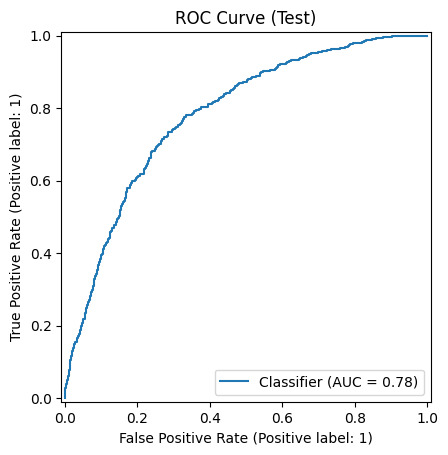

In [ ]:
# ===============================
# H) FINAL TEST EVALUATION
# ===============================
pred = best_model.predict(X_test)
proba = best_model.predict_proba(X_test)[:, 1]

print("\nTEST METRICS:")
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred))

print("\nClassification Report:")
print(classification_report(y_test, pred))

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve (Test)")
plt.show()


In [ ]:
# ===============================
# I) INTERPRETATION: PERMUTATION IMPORTANCE (top drivers)
# ===============================
# Permutation importance is model-agnostic but can be slow. Run on a sample if needed.
sample_idx = np.random.RandomState(42).choice(len(X_test), size=min(2000, len(X_test)), replace=False)
X_test_s = X_test.iloc[sample_idx]
y_test_s = y_test.iloc[sample_idx]

# Build feature names (after preprocessing + selection)
prep = best_model.named_steps["prep"]
fs = best_model.named_steps["fs"]

feature_names_num = num_cols
feature_names_cat = list(prep.named_transformers_["cat"].get_feature_names_out(cat_cols))
all_feature_names = feature_names_num + feature_names_cat

mask = fs.get_support()
selected_feature_names = np.array(all_feature_names)[mask]

# ===============================
# I) PERMUTATION IMPORTANCE (INPUT-LEVEL FEATURES)
# ===============================
perm = permutation_importance(
    best_model,
    X_test_s,
    y_test_s,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

imp_df = pd.DataFrame({
    "feature": X_test_s.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print("\nTop 15 important features (input-level):")
print(imp_df.head(15))




Top 15 important features (input-level):
           feature  importance_mean  importance_std
7           SPIN_T         0.099801        0.005979
6            SWL_T         0.093912        0.004404
2           Gender         0.007538        0.003097
1       Narcissism         0.004284        0.001041
12      motive_fun         0.002372        0.000851
4             Work         0.002333        0.000924
17     Playstyle_s         0.001363        0.001187
10     streams_log         0.001228        0.000545
9       Hours_band         0.000909        0.000626
8        Hours_log         0.000889        0.000907
19  Birthplace_top         0.000767        0.000605
14      motive_win         0.000506        0.000347
18   Residence_top         0.000491        0.000742
15    motive_relax         0.000387        0.000340
3              Age         0.000217        0.000267
